!cd /kaggle/working

# TSAI S18 - Part2 - VAE With MNIST

In [1]:
!pip install lightning-bolts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.8/300.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 51.8 MB/s eta 0:00:00
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 2.0.8
    Uninstalling pytorch-lightning-2.0.8:
      Successfully uninstalled pytorch-lightning-2.0.8


In [2]:
!rm -vrf TSAI_ERA_Assignments
!git clone https://github.com/ToletiSri/TSAI_ERA_Assignments.git

Cloning into 'TSAI_ERA_Assignments'...
remote: Enumerating objects: 529, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 529 (delta 4), reused 0 (delta 0), pack-reused 512
Receiving objects: 100% (529/529), 14.64 MiB | 14.38 MiB/s, done.
Resolving deltas: 100% (280/280), done.


In [3]:
cd TSAI_ERA_Assignments/S18/Part2

/kaggle/working/TSAI_ERA_Assignments/S18/Part2


In [4]:
import torch
from CustomVAE import VAE
from MNISTDataModule import MNISTDataModuleCustom

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/opt/conda/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed a

In [5]:
datamodule = MNISTDataModuleCustom()

In [6]:
import pytorch_lightning as pl

pl.seed_everything(1234)
model_vae = VAE()
trainer = pl.Trainer(gpus=1, max_epochs=11)
trainer.fit(model_vae, datamodule)

/kaggle/working/TSAI_ERA_Assignments/S18/Part2/CustomVAE.py:18: UnderReviewWarning: The feature resnet18_encoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.encoder = resnet18_encoder(False, False)
/opt/conda/lib/python3.10/site-packages/pl_bolts/models/autoencoders/components.py:334: UnderReviewWarning: The feature ResNetEncoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  return ResNetEncoder(EncoderBlock, [2, 2, 2, 2], first_conv, maxpool1)
/opt/conda/lib/python3.10/site-packages/pl_bolts/models/autoencode

100%|██████████| 9912422/9912422 [00:00<00:00, 338352264.82it/s]


Extracting data/MNISTtoRGB/raw/train-images-idx3-ubyte.gz to data/MNISTtoRGB/raw



100%|██████████| 28881/28881 [00:00<00:00, 43889744.14it/s]


Extracting data/MNISTtoRGB/raw/train-labels-idx1-ubyte.gz to data/MNISTtoRGB/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 153125017.08it/s]


Extracting data/MNISTtoRGB/raw/t10k-images-idx3-ubyte.gz to data/MNISTtoRGB/raw



100%|██████████| 4542/4542 [00:00<00:00, 2281773.72it/s]


Extracting data/MNISTtoRGB/raw/t10k-labels-idx1-ubyte.gz to data/MNISTtoRGB/raw



Training: 0it [00:00, ?it/s]

Training loss at end of epoch 0 = 2850.1162109375
Training loss at end of epoch 1 = 2435.3984375
Training loss at end of epoch 2 = 2128.260986328125
Training loss at end of epoch 3 = 1857.800537109375
Training loss at end of epoch 4 = 1552.1094970703125
Training loss at end of epoch 5 = 1326.2537841796875
Training loss at end of epoch 6 = 1064.9720458984375
Training loss at end of epoch 7 = 797.34033203125
Training loss at end of epoch 8 = 485.4376220703125
Training loss at end of epoch 9 = 243.0758514404297
Training loss at end of epoch 10 = 9.059609413146973


#### Plot Data

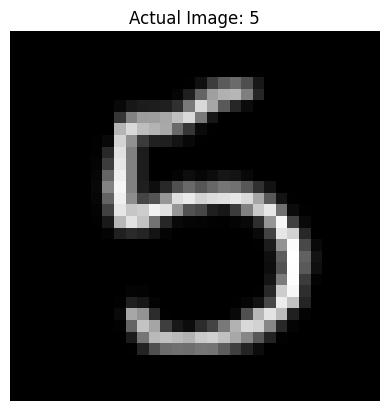

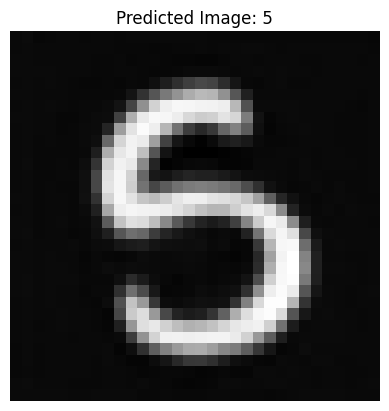

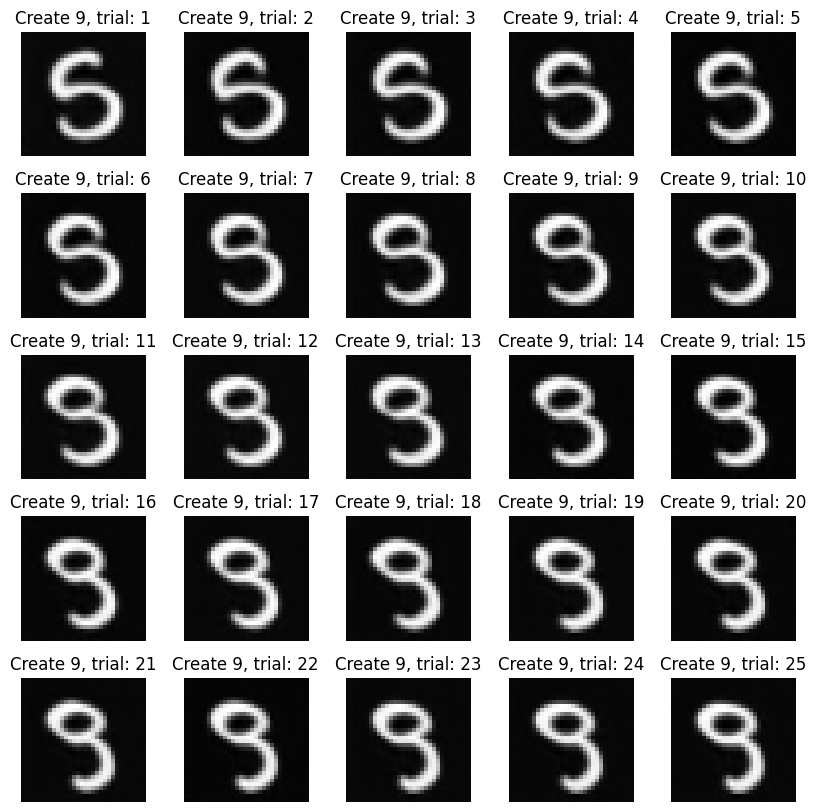

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import random

test_dl = datamodule.test_dataloader()
for batch in test_dl:
    images, label_ohe, label_ohe_random= batch
    break  # Break to get the first batch (a batch of images and labels)

# Select one image and its corresponding label
index = random.randint(0, 63)
image = images[index]
label_ohe_valid= label_ohe[index]
label_ohe_invalid = label_ohe_random[index]

label_valid = np.argmax(label_ohe_valid)
label_invalid = np.argmax(label_ohe_invalid)


# Plot the itest image
plt.imshow(image[0], cmap='gray')
plt.axis('off')
plt.title(f"Actual Image: {label_valid}")
plt.show()
image = image.unsqueeze(0)

with torch.no_grad():
    
    # Now pass this image through VAE encoder and plot the decoder output
    model_vae = model_vae.to('cuda')  # Move the entire model to GPU
    encoded_image = model_vae.encoder(image.to('cuda'))
    combined_features = torch.cat((encoded_image, label_ohe_valid.unsqueeze(0).to('cuda')), dim=1) #get OHE for label features
    
    mu, log_var = model_vae.fc_mu(combined_features), model_vae.fc_var(combined_features)

    # sample z from q
    std = torch.exp(log_var / 2)
    q = torch.distributions.Normal(mu, std)
    z = q.rsample()

    # decoded 
    decoded_image = model_vae.decoder(z).to('cpu').detach().numpy()

# Plot the generated image with actual label
plt.imshow(decoded_image[0,0], cmap='gray')
plt.axis('off')
plt.title(f"Predicted Image: {label_valid}")
plt.show()

decoded_images = []
decoded_images_plot = []
with torch.no_grad():
    
    for i in range(25):   
        if len(decoded_images) == 0:
            image = image
        else:
            image = decoded_images[-1]
        # Now pass this image through VAE encoder and plot the decoder output
        encoded_image = model_vae.encoder(image.to('cuda'))
        combined_features = torch.cat((encoded_image, label_ohe_invalid.unsqueeze(0).to('cuda')), dim=1) #get OHE for label features
        mu, log_var = model_vae.fc_mu(combined_features), model_vae.fc_var(combined_features)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded 
        decoded_image = model_vae.decoder(z)
        decoded_images.append(decoded_image)
        decoded_image = decoded_image.to('cpu').detach().numpy()
        decoded_images_plot.append(decoded_image[0, 0])

# Plot the 25 images

# Create a 5x5 grid of subplots
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

# Flatten the axes array so that we can iterate over it easily
axes = axes.flatten()

# Iterate through the images and plot them in the subplots
for i, ax in enumerate(axes):
    ax.imshow(decoded_images_plot[i], cmap='gray')  # Replace 'gray' with a colormap of your choice
    ax.set_title(f"Create {label_invalid}, trial: {i+1}")
    ax.axis('off')  # Turn off axis labels and ticks

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Display the plot
plt.show()

       
